# 8.4: Inspecting `HCLG.fst`

In the previous notebooks we ran `run_compile_graph.sh` which built a large `FST` called `HCLG.fst`.  And since we ran this command for **each** of the three acoustic models we built, you will see an `HCLG.fst` in each of the three "main" subdirectories of `exp`: `monophones`, `triphones`, and `triphones_lda`.

In [39]:
%%bash
ls -lah exp/monophones/graph/HCLG.fst

-rw-r--r-- 1 root root 436M Feb  1 21:51 exp/monophones/graph/HCLG.fst


In [40]:
%%bash
ls -lah exp/triphones/graph/HCLG.fst

ls: cannot access 'exp/triphones/graph/HCLG.fst': No such file or directory


In [41]:
%%bash
ls -lah exp/triphones_lda/graph/HCLG.fst

ls: cannot access 'exp/triphones_lda/graph/HCLG.fst': No such file or directory


The first thing you should notice is that, perhaps not surprisingly, the `HCLG` is larger for each of the subsequent levels of the acoustic model.

Before we inspect the `HCLG` in more detail, take the time to read [this **excellent** blog post](http://vpanayotov.blogspot.com/2012/06/kaldi-decoding-graph-construction.html) (from one of the main contributors of `kaldi`) that describes in detail the makeup of the `HCLG`.  

You'll also want to read **Section 6** of [this tutorial](https://github.com/michaelcapizzi/kaldi/blob/kaldi_instructional/egs/INSTRUCTIONAL/resource_files/resources/wfst_tutorial.pdf) which is a summary of the [original paper](https://github.com/michaelcapizzi/kaldi/blob/kaldi_instructional/egs/INSTRUCTIONAL/resource_files/resources/wfst_paper.pdf) introducing the idea of an `HCLG`.

## Building `HCLG`

The `HCLG` is a single `FST` that represents **all** aspects of our `ASR` pipeline into one graph.  As you read, it is the `composition` of **four** separate `FST`s (Note that they are `composed` in reverse order.

Decoding (when we take a new audio file and predict what was said) comes down to two steps:

   1. determining which `GMM` best matches the incoming frames
   2. looking for the most likely path through the graph

We can use the same packages we used last week to take a closer look at `HCLG` and its composites.

In [4]:
# because of the way `kaldi` installed `openFST` we have to add the path to the python functions here
import sys
sys.path.append("/scratch/kaldi/tools/openfst-1.6.2/lib/python2.7/site-packages")    

from utils.fst_manipulate import fst_manipulate as fstman  # scripts to further manipulate fsts

import pywrapfst as openfst  # the wrapper module
import graphviz as dot       # a wrapper for graphviz, which will allow us to visualize

### $G$

`G` is the `FST` representation of our `language model`.  We looked at this in detail in the last week's notebooks.  It has `word:word` on its edges.  Below is our `language model` built from the animal corpus.

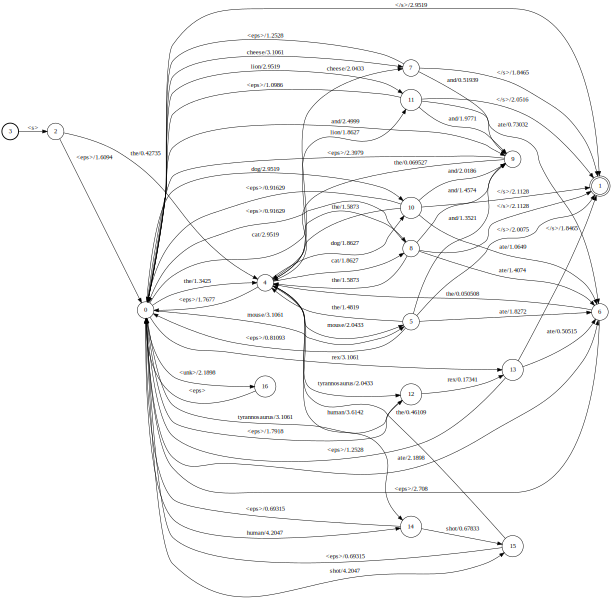

In [14]:
G_animal = openfst.Fst.read("resource_files/fst/animal_fst-2_gram.fst")
G_animal

The "real" `G.fst` can be found in `data/lang_test_tg` and was built way back in week 3 when we ran `run_prepare_data.sh` to build the `data` directory.

**Note:** These composite `FST`s will be too big to visualize, but we can still gather some information about them.

In [37]:
%%bash
ls -lah data/lang_test_tg/G.fst

-rw-r--r-- 1 root root 55M Feb  1 21:03 data/lang_test_tg/G.fst


In [6]:
G = openfst.Fst.read("data/lang_test_tg/G.fst")

We can calculate the number of states by converting the `iterator` in `.states()` to a `<list>` and getting its length.

In [7]:
G_states = len(list(G.states()))
G_states

1178044

We can do a similar thing with the `.arcs()` `iterator` with a small modification.  `.arcs()` takes one argument, a `state`, and so we loop through all `state`s, and then count how many `arc`s that state has.

In [8]:
G_arcs = 0
for s in G.states():
    intermediate_arcs = len(list(G.arcs(s)))
    G_arcs += intermediate_arcs
G_arcs

2659792

We can also get some information about the `arc`s.

**Note:** We'll just look at the first **five** states and then `break` out of our nested `for` loops.

In [9]:
c = 0
for s in G.states():
    for a in G.arcs(s):
        if c < 5:
            print("in: {}\nout: {}\nweight: {}".format(
                a.ilabel,
                a.olabel,
                a.weight
                )
            )
            print("=========")
        else:
            break
        c += 1
    break

in: 2
out: 2
weight: 4.15409374
in: 49
out: 49
weight: 10.8683262
in: 220
out: 220
weight: 10.9160538
in: 227
out: 227
weight: 10.9750328
in: 456
out: 456
weight: 7.23240852


Remember that `openfst` will use `index`es instead of `string`s on the `arc`s, but we can recover the words by looking at the "lookup" file `kaldi` built for this very purpose.

In [10]:
%%bash
cat data/lang/words.txt | grep -E " 2$"       # the -E flag will allow us to use a regex
cat data/lang/words.txt | grep -E " 49$"
cat data/lang/words.txt | grep -E " 220$"
cat data/lang/words.txt | grep -E " 227$"
cat data/lang/words.txt | grep -E " 456$"

A 2
AARON 49
ABE 220
ABEL 227
ABOUT 456


You'll notice that the `ilabel` and `olabel` are the same, confirming that the `arc`s consist of `word:word`.  And the `weight` is the representation of the probability (see `7.2 Examining G_fst`).

### $L$
`L` is the `FST` representation of our `lexicon`.  This was built in week 3 when we built the `data` directory (see `3.2: Inspecting data dir`).  

In [11]:
ls -lah data/lang/ | grep L

-rw-r--r-- 1 root root  37M Feb  1 21:00 L.fst
-rw-r--r-- 1 root root  38M Feb  1 21:00 L_disambig.fst


In [12]:
L = openfst.Fst.read("data/lang/L.fst")

In [51]:
c = 0
for s in L.states():
    for a in L.arcs(s):
        if c < 15:
            print("in: {}\nout: {}\nweight: {}".format(
                a.ilabel,
                a.olabel,
                a.weight
                )
            )
            print("=========")
        else:
            break
        c += 1
    if c > 15:
        break

in: 0
out: 0
weight: 0.693147182
in: 1
out: 0
weight: 0.693147182
in: 5
out: 1
weight: 0.693147182
in: 5
out: 1
weight: 0.693147182
in: 33
out: 2
weight: 0.693147182
in: 125
out: 2
weight: 0.693147182
in: 33
out: 2
weight: 0.693147182
in: 125
out: 2
weight: 0.693147182
in: 122
out: 3
weight: 0
in: 122
out: 4
weight: 0
in: 122
out: 5
weight: 0
in: 122
out: 6
weight: 0
in: 122
out: 7
weight: 0
in: 122
out: 8
weight: 0
in: 122
out: 9
weight: 0


`L` has a different `arc` structure, consisting of `phone:word`.  And so to understand these `arc`s we need to also access the `phones` "lookup".

In [53]:
%%bash
cat data/lang/phones.txt | grep -E " 122$"
cat data/lang/words.txt | grep -E " 8$"

EY1_B 122
A'GOIN 8


It's not clear what the `weight` represents, but you'll notice that it's almost always **the same** value (or 0).  So if the weight is equal for all `arc`s, it is essentially unimportant in determining shortest path.

**Note:** You may also be wondering how this will work for words consisting of more than one phone.  The **first** `arc` will have `phone:word` and each subsequent arc will have `phone:<eps>` (`<eps>` representing $epsilon$, or the empty `arc`).  You can see an example of this in the visualization of $L$ in this [blog post](http://vpanayotov.blogspot.com/2012/06/kaldi-decoding-graph-construction.html).

### $LG = L \circ G$

When we `compose` `L` and `G`, we will get a representation that incorporates **both** spelling **and** language model information.  We will end up with an `FST` that has the `arc` structure of `phone:word`.  

**Note:** In general, a `composition` will keep the arc **`input`** of the first `FST` and the arc **`output`** of the second `FST`.

If you did **NOT** delete the `tmp` folder in `data/lang_test_tg`, then you'll have a copy of an `LG.fst` built from the last `run_compile_graph.sh` command you ran.

In [42]:
%%bash
ls -lah data/lang_test_tg/tmp/LG.fst

-rw-r--r-- 1 root root 0 Feb  2 16:40 data/lang_test_tg/tmp/LG.fst


It shouldn't be surprising that it is **much** larger than `L` and `G`.

In [28]:
LG = openfst.Fst.read("data/lang_test_tg/tmp/LG.fst")

In [43]:
c = 0
for s in LG.states():
    for a in LG.arcs(s):
        if c < 10:
            print("in: {}\nout: {}\nweight: {}".format(
                a.ilabel,
                a.olabel,
                a.weight
                )
            )
            print("=========")
        else:
            break
        c += 1
    if c > 10:
        break

in: 1
out: 0
weight: 0.696051657
in: 6
out: 0
weight: 11.6102352
in: 10
out: 0
weight: 5.62995577
in: 13
out: 2571
weight: 7.73233223
in: 14
out: 79970
weight: 12.1902256
in: 18
out: 0
weight: 11.6942472
in: 22
out: 0
weight: 3.66675067
in: 26
out: 0
weight: 10.6096516
in: 30
out: 0
weight: 3.96394253
in: 33
out: 2
weight: 5.47279119


In [45]:
%%bash
cat data/lang/phones.txt | grep -E " 14$"
cat data/lang/words.txt | grep -E " 79970$"

AA2_B 14
HENRI 79970


And remember that the `arc` `weights` from $G$ represented the language model probabilities, so these are propogated to $LG$.

### $C$

The `C.fst` is a representation of the `triphone` information from our acoustic model. 

**Note:** This `FST` isn't explicitly built in `kaldi` as a standalone item.  But [this blog post](http://vpanayotov.blogspot.com/2012/06/kaldi-decoding-graph-construction.html) has an image of what it looks like.  It also explains the indexing in a very straightforward manner:

 ```
 The input symbols of the C graph are triphone IDs, which are specified by using a Kaldi-specific data structure called ilabel_info(frankly clabel_info would have been more intuitive name for me, but perhaps there is reason it's called that way). Basically this is an array of arrays, where the the indices of the first dimension are the triphone IDs and the individual entries of the nested arrays are the IDs of the context-independent phones, which constitute the context window for the particular triphone. For example if there are triphone "a/b/c"(i.e. central phone "b" with left context "a" and right context "c") with id "10" the eleventh entry in the ilabel_info will be an array containing the context-independent ID's of the phones "a", "b" and "c".```
 
So to summarize, the `arc` structure is `triphone:phone`.

### $CLG = C \circ LG$

Since this is a composition of `C` (`arc` structure of `triphone:phone`) and `LG` (`arc` structure of `phone:word`), the resulting `FST` will have `arc` structure of `triphone:word`.  And the `arc` `weight` are again a propogation of our language model probabilities.